<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br/social

Na aula anterior criamos nosso primeiro modelo de Deep Learning para a Previsão da Média Mensal de Vendas. Agora vamos trabalhar na otimização do modelo e começaremos com um modelo Stacked LSTM. 

**Deep Learning - O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning**

Deep Learning é uma tentativa de reproduzir nas máquinas a capacidade de inteligência humana. Logo, se aumentarmos o número de camadas do modelo e aumentarmos o número de neurônios matemáticos, nosso modelo de Deep Learning fica mais "inteligente", ou seja, mais preciso. Certo? Não necessariamente!

Sei que você não quer ouvir isso, mas a verdade precisa ser dita: Tudo depende do seu problema e do seu conjunto de dados!

Para alguns problemas, a simples adição de camadas e/ou neurônios promove um aumento significativo na precisão do modelo. Para outros casos (como o nosso), pode ser um desastre. Por isso, não use o aumento de camadas/neurônios como a sua única estratégia para tentar melhorar a performance de um modelo de Deep Learning.

Vejamos o que acontece quando criamos uma rede realmente profunda!

Esta aula considera algu conhecimento em Deep Learning e esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Imports para modelagem preditiva - Tensorflow 1.
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [3]:
# Imports para modelagem preditiva - Tensorflow 2.0
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import Sequential, optimizers
#from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels.api 0.11.1
seaborn         0.10.1
pandas          1.0.5
keras           2.3.1
sklearn         0.23.1
statsmodels     0.11.1
matplotlib      3.3.0
numpy           1.16.6
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [5]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [6]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [7]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['QT_INTER']

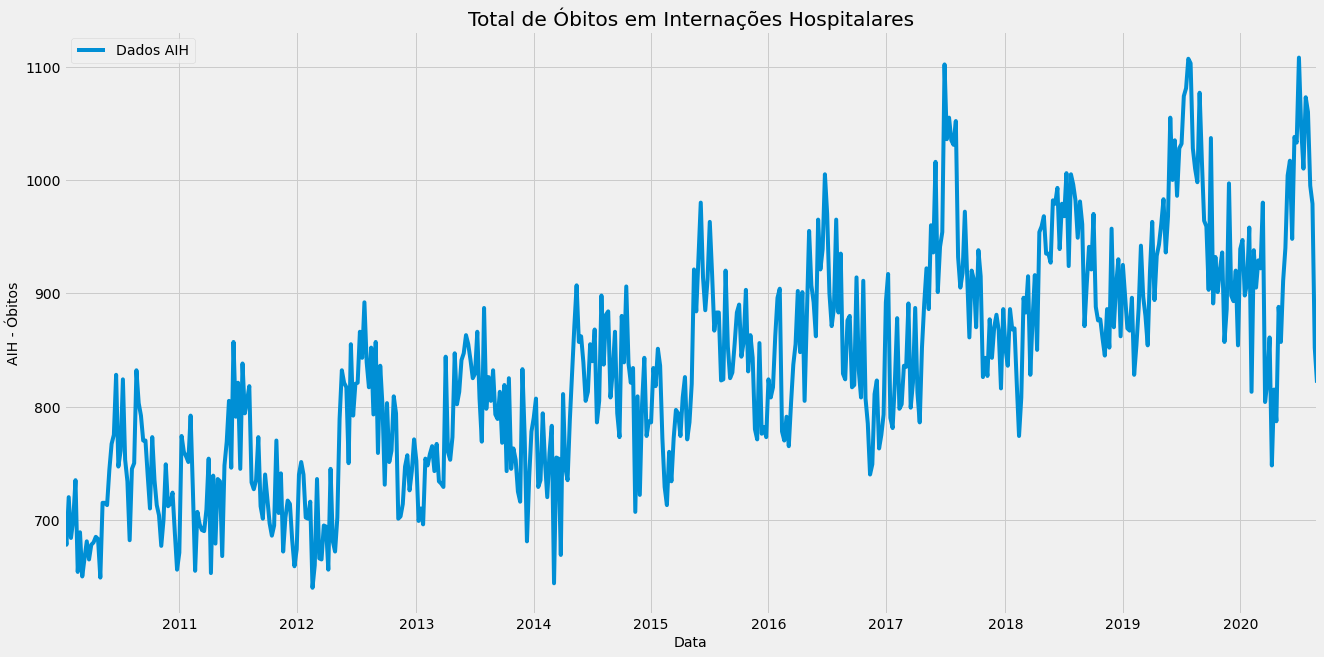

In [8]:
# Plot
target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

In [9]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

417 139


In [10]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

### Função Para o Cálculo da Acurácia

In [11]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning

Nesta aula tentaremos aumentar a precisão do nosso modelo aumentando de forma significativa o número de camadas e neurônios.

Execute o modelo e tire suas conclusões.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados.

In [12]:
# Transforma a série temporal em um problema de aprendizagem supervisionada
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

In [13]:
# Cria uma série diferenciada para tornar a série temporal estacionária
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [14]:
# Inverte valor diferenciado
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[-interval]

In [15]:
# Transforma a série temporal em estacionária
raw_values = target.values
diff_values = difference(raw_values, 1)

In [17]:
# Transforma a série temporal em aprendizado supervisionado
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [18]:
# Criação do dataset de treino e teste
trainset, testset = supervised_values[0:-138], supervised_values[-138:]

In [19]:
# Normalizamos os dados aplicando scala no intervalo [-1, 1]
def scale(train, test):
    scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = scaler.fit(train)
    
    # Transforma dados de treino
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # Transforma dados de teste
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [20]:
#  Inverte a escala nas previsões para a escala original
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [21]:
# Transforma a escala dos dados
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [104]:
# Função para o modelo LSTM
def train_lstm(train, nb_epoch):
    
    # Ajusta o shape dos dados
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # Modelo
    modelo_lstm = Sequential()
    modelo_lstm.add(LSTM(200, activation = 'relu', return_sequences = True, input_shape = (1, 1)))
    modelo_lstm.add(LSTM(100, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(50, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(25, activation = 'relu'))
    modelo_lstm.add(Dense(20, activation = 'relu'))
    modelo_lstm.add(Dense(10, activation = 'relu'))
    modelo_lstm.add(Dense(1))
    
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

    modelo_lstm.fit(X, y, epochs = nb_epoch, verbose = 1)
    
    return modelo_lstm

> Vamos treinar por 5 mil épocas.

In [105]:
# Treinamento
start = time()

lstm_model = train_lstm(train_scaled, 5000)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/5000
417/417 [==============================] - 2s 4ms/step - loss: 0.1292
Epoch 2/5000
417/417 [==============================] - 0s 537us/step - loss: 0.1292
Epoch 3/5000
417/417 [==============================] - 0s 522us/step - loss: 0.1290
Epoch 4/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1285
Epoch 5/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1281
Epoch 6/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1264
Epoch 7/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1234
Epoch 8/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1211
Epoch 9/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1156
Epoch 10/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1105
Epoch 11/5000
417/417 [==============================] - 0s 527us/step - loss: 0.1101
Epoch 12/5000
417/417 [==============================] - 0s 525us

417/417 [==============================] - 0s 501us/step - loss: 0.1059
Epoch 191/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1063
Epoch 192/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1070
Epoch 193/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1064
Epoch 194/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1069
Epoch 195/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1063
Epoch 196/5000
417/417 [==============================] - 0s 491us/step - loss: 0.1062
Epoch 197/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1068
Epoch 198/5000
417/417 [==============================] - 0s 520us/step - loss: 0.1063
Epoch 199/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1061
Epoch 200/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1071
Epoch 201/5000
417/417 [==============================] - 

417/417 [==============================] - 0s 508us/step - loss: 0.1057
Epoch 379/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1074
Epoch 380/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1065
Epoch 381/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1067
Epoch 382/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1070
Epoch 383/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1093
Epoch 384/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1096
Epoch 385/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1095
Epoch 386/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1097
Epoch 387/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1085
Epoch 388/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1080
Epoch 389/5000
417/417 [==============================] - 

417/417 [==============================] - 0s 515us/step - loss: 0.1061
Epoch 567/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1058
Epoch 568/5000
417/417 [==============================] - 0s 522us/step - loss: 0.1061
Epoch 569/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1062
Epoch 570/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1063
Epoch 571/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1071
Epoch 572/5000
417/417 [==============================] - 0s 534us/step - loss: 0.1061
Epoch 573/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1058
Epoch 574/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1058
Epoch 575/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1061
Epoch 576/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1077
Epoch 577/5000
417/417 [==============================] - 

417/417 [==============================] - 0s 522us/step - loss: 0.1065
Epoch 755/5000
417/417 [==============================] - 0s 551us/step - loss: 0.1071
Epoch 756/5000
417/417 [==============================] - 0s 467us/step - loss: 0.1063
Epoch 757/5000
417/417 [==============================] - 0s 474us/step - loss: 0.1059
Epoch 758/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1063
Epoch 759/5000
417/417 [==============================] - 0s 534us/step - loss: 0.1060
Epoch 760/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1060
Epoch 761/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1058
Epoch 762/5000
417/417 [==============================] - 0s 704us/step - loss: 0.1057
Epoch 763/5000
417/417 [==============================] - 0s 580us/step - loss: 0.1056
Epoch 764/5000
417/417 [==============================] - 0s 570us/step - loss: 0.1055
Epoch 765/5000
417/417 [==============================] - 

417/417 [==============================] - 0s 513us/step - loss: 0.1064
Epoch 943/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1067
Epoch 944/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1077
Epoch 945/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1071
Epoch 946/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1065
Epoch 947/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1079
Epoch 948/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1068
Epoch 949/5000
417/417 [==============================] - 0s 491us/step - loss: 0.1061
Epoch 950/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1064
Epoch 951/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1062
Epoch 952/5000
417/417 [==============================] - 0s 491us/step - loss: 0.1078
Epoch 953/5000
417/417 [==============================] - 

Epoch 1036/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1062
Epoch 1037/5000
417/417 [==============================] - 0s 491us/step - loss: 0.1064
Epoch 1038/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1072
Epoch 1039/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1063
Epoch 1040/5000
417/417 [==============================] - 0s 525us/step - loss: 0.1062
Epoch 1041/5000
417/417 [==============================] - 0s 537us/step - loss: 0.1062
Epoch 1042/5000
417/417 [==============================] - 0s 553us/step - loss: 0.1063
Epoch 1043/5000
417/417 [==============================] - 0s 577us/step - loss: 0.1060
Epoch 1044/5000
417/417 [==============================] - 0s 565us/step - loss: 0.1061
Epoch 1045/5000
417/417 [==============================] - 0s 546us/step - loss: 0.1061
Epoch 1046/5000
417/417 [==============================] - 0s 561us/step - loss: 0.1063
Epoch 1047/5000
417/417 [=======

417/417 [==============================] - 0s 503us/step - loss: 0.1066
Epoch 1130/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1064
Epoch 1131/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1063
Epoch 1132/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1065
Epoch 1133/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1063
Epoch 1134/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1067
Epoch 1135/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1076
Epoch 1136/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1064
Epoch 1137/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1061
Epoch 1138/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1063
Epoch 1139/5000
417/417 [==============================] - 0s 491us/step - loss: 0.1060
Epoch 1140/5000
417/417 [=======================

417/417 [==============================] - 0s 510us/step - loss: 0.1054
Epoch 1316/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1054
Epoch 1317/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1054
Epoch 1318/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1054
Epoch 1319/5000
417/417 [==============================] - 0s 534us/step - loss: 0.1056
Epoch 1320/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1071
Epoch 1321/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1065
Epoch 1322/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1064
Epoch 1323/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1061
Epoch 1324/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1058
Epoch 1325/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1057
Epoch 1326/5000
417/417 [=======================

417/417 [==============================] - 0s 491us/step - loss: 0.1055
Epoch 1502/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1055
Epoch 1503/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1055
Epoch 1504/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1055
Epoch 1505/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1055
Epoch 1506/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1055
Epoch 1507/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1054
Epoch 1508/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1055
Epoch 1509/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1058
Epoch 1510/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1059
Epoch 1511/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1081
Epoch 1512/5000
417/417 [=======================

417/417 [==============================] - 0s 505us/step - loss: 0.1058
Epoch 1688/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1058
Epoch 1689/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1056
Epoch 1690/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1056
Epoch 1691/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1058
Epoch 1692/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1055
Epoch 1693/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1063
Epoch 1694/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1070
Epoch 1695/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1058
Epoch 1696/5000
417/417 [==============================] - 0s 527us/step - loss: 0.1055
Epoch 1697/5000
417/417 [==============================] - 0s 537us/step - loss: 0.1054
Epoch 1698/5000
417/417 [=======================

417/417 [==============================] - 0s 520us/step - loss: 0.1056
Epoch 1874/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1057
Epoch 1875/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1059
Epoch 1876/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1057
Epoch 1877/5000
417/417 [==============================] - 0s 491us/step - loss: 0.1060
Epoch 1878/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1054
Epoch 1879/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1057
Epoch 1880/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1064
Epoch 1881/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1072
Epoch 1882/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1065
Epoch 1883/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1058
Epoch 1884/5000
417/417 [=======================

417/417 [==============================] - 0s 508us/step - loss: 0.1068
Epoch 2060/5000
417/417 [==============================] - 0s 613us/step - loss: 0.1069
Epoch 2061/5000
417/417 [==============================] - 0s 484us/step - loss: 0.1067
Epoch 2062/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1068
Epoch 2063/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1070
Epoch 2064/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1075
Epoch 2065/5000
417/417 [==============================] - 0s 484us/step - loss: 0.1070
Epoch 2066/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1068
Epoch 2067/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1068
Epoch 2068/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1069
Epoch 2069/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1082
Epoch 2070/5000
417/417 [=======================

417/417 [==============================] - 0s 513us/step - loss: 0.1051
Epoch 2246/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1046
Epoch 2247/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1049
Epoch 2248/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1051
Epoch 2249/5000
417/417 [==============================] - 0s 534us/step - loss: 0.1066
Epoch 2250/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1068
Epoch 2251/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1066
Epoch 2252/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1067
Epoch 2253/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1065
Epoch 2254/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1060
Epoch 2255/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1096
Epoch 2256/5000
417/417 [=======================

417/417 [==============================] - 0s 501us/step - loss: 0.1060
Epoch 2432/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1061
Epoch 2433/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1061
Epoch 2434/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1064
Epoch 2435/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1071
Epoch 2436/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1074
Epoch 2437/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1075
Epoch 2438/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1073
Epoch 2439/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1069
Epoch 2440/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1080
Epoch 2441/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1073
Epoch 2442/5000
417/417 [=======================

417/417 [==============================] - 0s 501us/step - loss: 0.1055
Epoch 2618/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1072
Epoch 2619/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1059
Epoch 2620/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1059
Epoch 2621/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1056
Epoch 2622/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1051
Epoch 2623/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1052
Epoch 2624/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1051
Epoch 2625/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1053
Epoch 2626/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1057
Epoch 2627/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1055
Epoch 2628/5000
417/417 [=======================

417/417 [==============================] - 0s 532us/step - loss: 0.1065
Epoch 2711/5000
417/417 [==============================] - 0s 568us/step - loss: 0.1063
Epoch 2712/5000
417/417 [==============================] - 0s 558us/step - loss: 0.1060
Epoch 2713/5000
417/417 [==============================] - 0s 570us/step - loss: 0.1061
Epoch 2714/5000
417/417 [==============================] - 0s 573us/step - loss: 0.1064
Epoch 2715/5000
417/417 [==============================] - 0s 640us/step - loss: 0.1060
Epoch 2716/5000
417/417 [==============================] - 0s 565us/step - loss: 0.1058
Epoch 2717/5000
417/417 [==============================] - 0s 606us/step - loss: 0.1057
Epoch 2718/5000
417/417 [==============================] - 0s 664us/step - loss: 0.1057
Epoch 2719/5000
417/417 [==============================] - 0s 546us/step - loss: 0.1058
Epoch 2720/5000
417/417 [==============================] - 0s 522us/step - loss: 0.1062
Epoch 2721/5000
417/417 [=======================

417/417 [==============================] - 0s 501us/step - loss: 0.1044
Epoch 2897/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1043
Epoch 2898/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1043
Epoch 2899/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1042
Epoch 2900/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1042
Epoch 2901/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1043
Epoch 2902/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1042
Epoch 2903/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1043
Epoch 2904/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1043
Epoch 2905/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1044
Epoch 2906/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1043
Epoch 2907/5000
417/417 [=======================

417/417 [==============================] - 0s 505us/step - loss: 0.1048
Epoch 3083/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1048
Epoch 3084/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1049
Epoch 3085/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1047
Epoch 3086/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1047
Epoch 3087/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1051
Epoch 3088/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1050
Epoch 3089/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1047
Epoch 3090/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1047
Epoch 3091/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1049
Epoch 3092/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1046
Epoch 3093/5000
417/417 [=======================

417/417 [==============================] - 0s 525us/step - loss: 0.1045
Epoch 3269/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1050
Epoch 3270/5000
417/417 [==============================] - 0s 525us/step - loss: 0.1052
Epoch 3271/5000
417/417 [==============================] - 0s 529us/step - loss: 0.1068
Epoch 3272/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1060
Epoch 3273/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1051
Epoch 3274/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1052
Epoch 3275/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1053
Epoch 3276/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1050
Epoch 3277/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1050
Epoch 3278/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1054
Epoch 3279/5000
417/417 [=======================

417/417 [==============================] - 0s 534us/step - loss: 0.1043
Epoch 3455/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1047
Epoch 3456/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1049
Epoch 3457/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1045
Epoch 3458/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1048
Epoch 3459/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1045
Epoch 3460/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1047
Epoch 3461/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1047
Epoch 3462/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1050
Epoch 3463/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1053
Epoch 3464/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1049
Epoch 3465/5000
417/417 [=======================

417/417 [==============================] - 0s 510us/step - loss: 0.1043
Epoch 3641/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1038
Epoch 3642/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1041
Epoch 3643/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1046
Epoch 3644/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1042
Epoch 3645/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1040
Epoch 3646/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1041
Epoch 3647/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1045
Epoch 3648/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1042
Epoch 3649/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1037
Epoch 3650/5000
417/417 [==============================] - 0s 491us/step - loss: 0.1048
Epoch 3651/5000
417/417 [=======================

417/417 [==============================] - 0s 498us/step - loss: 0.1046
Epoch 3827/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1048
Epoch 3828/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1047
Epoch 3829/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1045
Epoch 3830/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1053
Epoch 3831/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1044
Epoch 3832/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1041
Epoch 3833/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1039
Epoch 3834/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1039
Epoch 3835/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1037
Epoch 3836/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1037
Epoch 3837/5000
417/417 [=======================

417/417 [==============================] - 0s 565us/step - loss: 0.1024
Epoch 4013/5000
417/417 [==============================] - 0s 539us/step - loss: 0.1027
Epoch 4014/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1024
Epoch 4015/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1020
Epoch 4016/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1022
Epoch 4017/5000
417/417 [==============================] - 0s 532us/step - loss: 0.1025
Epoch 4018/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1022
Epoch 4019/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1029
Epoch 4020/5000
417/417 [==============================] - 0s 515us/step - loss: 0.1031
Epoch 4021/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1027
Epoch 4022/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1025
Epoch 4023/5000
417/417 [=======================

417/417 [==============================] - 0s 508us/step - loss: 0.1063
Epoch 4199/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1050
Epoch 4200/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1046
Epoch 4201/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1044
Epoch 4202/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1045
Epoch 4203/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1049
Epoch 4204/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1047
Epoch 4205/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1046
Epoch 4206/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1084
Epoch 4207/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1102
Epoch 4208/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1077
Epoch 4209/5000
417/417 [=======================

417/417 [==============================] - 0s 529us/step - loss: 0.1049
Epoch 4385/5000
417/417 [==============================] - 0s 520us/step - loss: 0.1052
Epoch 4386/5000
417/417 [==============================] - 0s 527us/step - loss: 0.1055
Epoch 4387/5000
417/417 [==============================] - 0s 484us/step - loss: 0.1044
Epoch 4388/5000
417/417 [==============================] - 0s 496us/step - loss: 0.1044
Epoch 4389/5000
417/417 [==============================] - 0s 489us/step - loss: 0.1048
Epoch 4390/5000
417/417 [==============================] - 0s 493us/step - loss: 0.1050
Epoch 4391/5000
417/417 [==============================] - 0s 491us/step - loss: 0.1062
Epoch 4392/5000
417/417 [==============================] - 0s 481us/step - loss: 0.1044
Epoch 4393/5000
417/417 [==============================] - 0s 565us/step - loss: 0.1043
Epoch 4394/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1041
Epoch 4395/5000
417/417 [=======================

417/417 [==============================] - 0s 508us/step - loss: 0.1044
Epoch 4571/5000
417/417 [==============================] - 0s 563us/step - loss: 0.1033
Epoch 4572/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1027
Epoch 4573/5000
417/417 [==============================] - 0s 520us/step - loss: 0.1033
Epoch 4574/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1035
Epoch 4575/5000
417/417 [==============================] - 0s 563us/step - loss: 0.1027
Epoch 4576/5000
417/417 [==============================] - 0s 541us/step - loss: 0.1023
Epoch 4577/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1025
Epoch 4578/5000
417/417 [==============================] - 0s 647us/step - loss: 0.1022
Epoch 4579/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1025
Epoch 4580/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1020
Epoch 4581/5000
417/417 [=======================

417/417 [==============================] - 0s 517us/step - loss: 0.1062
Epoch 4664/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1062
Epoch 4665/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1062
Epoch 4666/5000
417/417 [==============================] - 0s 505us/step - loss: 0.1063
Epoch 4667/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1064
Epoch 4668/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1062
Epoch 4669/5000
417/417 [==============================] - 0s 513us/step - loss: 0.1059
Epoch 4670/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1057
Epoch 4671/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1057
Epoch 4672/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1057
Epoch 4673/5000
417/417 [==============================] - 0s 601us/step - loss: 0.1059
Epoch 4674/5000
417/417 [=======================

417/417 [==============================] - 0s 515us/step - loss: 0.1032
Epoch 4850/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1030
Epoch 4851/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1026
Epoch 4852/5000
417/417 [==============================] - 0s 498us/step - loss: 0.1025
Epoch 4853/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1024
Epoch 4854/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1023
Epoch 4855/5000
417/417 [==============================] - 0s 510us/step - loss: 0.1027
Epoch 4856/5000
417/417 [==============================] - 0s 503us/step - loss: 0.1024
Epoch 4857/5000
417/417 [==============================] - 0s 508us/step - loss: 0.1031
Epoch 4858/5000
417/417 [==============================] - 0s 517us/step - loss: 0.1025
Epoch 4859/5000
417/417 [==============================] - 0s 501us/step - loss: 0.1025
Epoch 4860/5000
417/417 [=======================

In [106]:
# Forecast em todo o conjunto de dados de treinamento para construir o estado da previsão
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#lstm_model.predict(train_reshaped)

In [107]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X)
    return yhat[0,0]

In [108]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões
for i in range(len(test_scaled)):
    
    # Ajusta o shape dos dados de teste
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    
    # Previsão
    yhat = forecast_lstm(lstm_model, X)
    
    # Inverte a escala
    yhat = invert_scale(scaler, X, yhat)
    
    # Inverte a diferenciação
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

Mês = 1, Valor Previsto = 869.994183, Valor Esperado = 851.000000
Mês = 2, Valor Previsto = 857.631215, Valor Esperado = 836.000000
Mês = 3, Valor Previsto = 858.402016, Valor Esperado = 886.000000
Mês = 4, Valor Previsto = 890.012321, Valor Esperado = 868.000000
Mês = 5, Valor Previsto = 880.661061, Valor Esperado = 869.000000
Mês = 6, Valor Previsto = 838.058102, Valor Esperado = 820.000000
Mês = 7, Valor Previsto = 790.989852, Valor Esperado = 774.000000
Mês = 8, Valor Previsto = 801.789591, Valor Esperado = 808.000000
Mês = 9, Valor Previsto = 853.616198, Valor Esperado = 896.000000
Mês = 10, Valor Previsto = 903.377418, Valor Esperado = 883.000000
Mês = 11, Valor Previsto = 907.685035, Valor Esperado = 915.000000
Mês = 12, Valor Previsto = 874.320059, Valor Esperado = 828.000000
Mês = 13, Valor Previsto = 849.952363, Valor Esperado = 877.000000
Mês = 14, Valor Previsto = 896.193635, Valor Esperado = 916.000000
Mês = 15, Valor Previsto = 881.120115, Valor Esperado = 850.000000
Mês 

Mês = 135, Valor Previsto = 1080.377418, Valor Esperado = 1060.000000
Mês = 136, Valor Previsto = 1025.806660, Valor Esperado = 995.000000
Mês = 137, Valor Previsto = 1000.781253, Valor Esperado = 979.000000
Mês = 138, Valor Previsto = 876.505304, Valor Esperado = 852.000000


In [109]:
# Calculamos e imprimos a performance do modelo
dados_teste_original = target[-138:]
dados_teste_original = dados_teste_original.values.reshape(138,1)
modelo_lstm_performance = performance(dados_teste_original, previsoes_lstm)
#modelo_lstm_performance

MSE das previsões é 10052.8939
RMSE das previsões é 100.2641
MAPE das previsões é 8.6613


Observe o que aconteceu. Uma das técnicas de aprendizagem de máquina do planeta agora é o pior modelo que criamos entre todas as versões até aqui. 

E o que deveria ter melhorado a precisão do modelo (mais camadas e mais neurônios) na verdade de mostrou um desastre. Por isso, como profissional, você deve dominar as técnicas do processo e não contar com a apenas uma estratégia. cada problema vai querer uma abordagem diferente.

Vamos finalizar o trabalho como fizemos nas aulas anteriores.

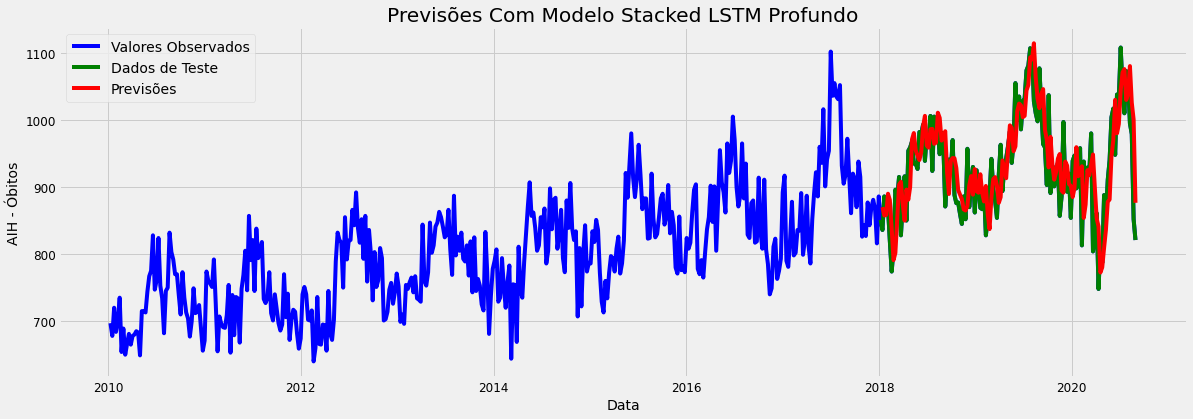

In [111]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(target[418:].index, previsoes_lstm, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo Stacked LSTM Profundo')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left')
plt.show()

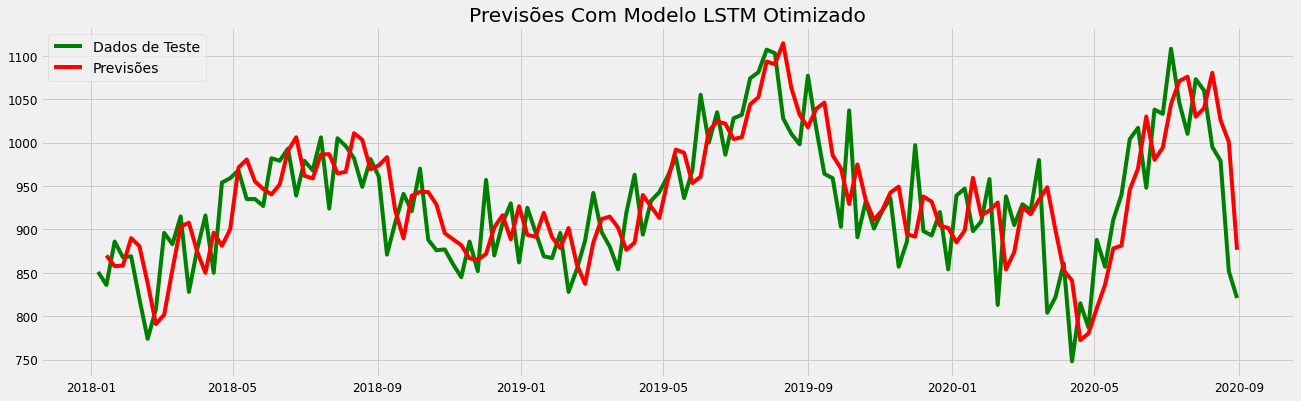

In [113]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[418:].index, previsoes_lstm, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Otimizado')
plt.legend(loc = 'upper left')
plt.show()

Vamos fazer o Forecasting para 24 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [114]:
# Última data da série
target.index[-1]

Timestamp('2020-08-30 00:00:00', freq='W-SUN')

In [115]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(weeks = x) for x in range(0, 139)]

In [116]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [117]:
# Nossa série original é um objeto do tipo pd.Series
#type(arrecadacao_icms)

In [118]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [119]:
# Visualiza os dados
#df_original.head()

In [120]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [121]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
#data_futuras

In [122]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(previsoes_lstm,
                          index = data_futuras.index, columns = ['Prediction'])

In [123]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [124]:
# Visualiza o dataframe
#df_forecasting

### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 24 meses que correspondem aos 24 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 24 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

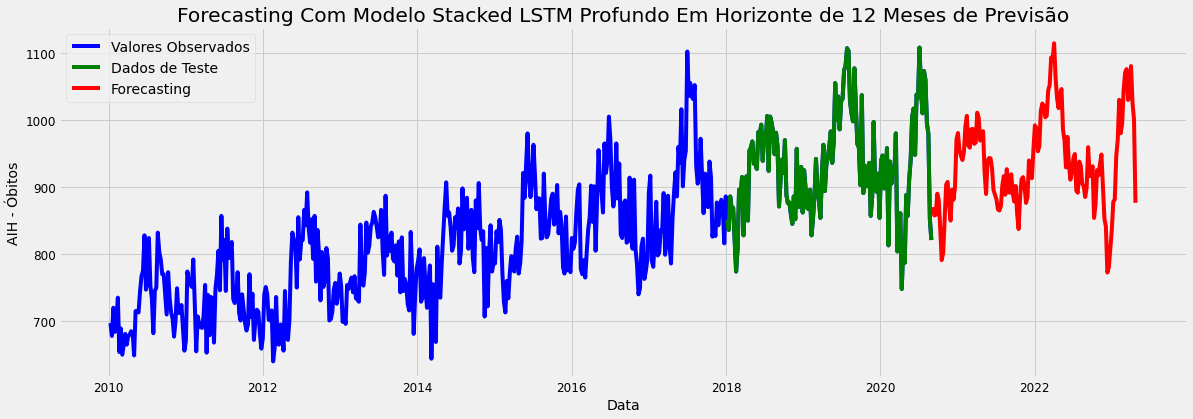

In [125]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo Stacked LSTM Profundo Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend()
plt.show()

Graficamente o resultado não parece tão ruim, mas as métricas demonstram que esse modelo é o pior de todos, ainda possa até mesmo ser usado na falta de outra opção.

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (4,5) - AIC = 38735.11 e RMSE = 236.8709
- Modelo 16 --> Modelo ARIMA Forcast (5,1,2) - AIC = 39559.670 e RMSE = 459.1013
- Modelo 17 --> Modelo SARIMA (2, 1, 2)x(2, 1, 0, 12) - AIC = 4104.139 e RMSE = 197.0291
- Modelo 18 --> Modelo SARIMA (0, 1, 1)x(0, 1, 1, 12) - AIC = 4131.634 e RMSE = 81.8482
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 11.3762 e RMSE = 130.1589   -   (3 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.2775 e RMSE = 120.1346   -   (5 repetições)
- Modelo 23 --> Modelo Stacked LSTM - MAPE = 8.3069 e RMSE = 98.5724   -   (3 repetições)
- Modelo 24 --> Modelo Stacked LSTM Profundo - MAPE = 8.6613 e RMSE = 100.2641 

Mas.....ainda não fizemos otimização de hiperparâmetros do modelo! 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim